# Independent Component Analysis

#### Blaire Li, Liwen Zhang 


## Abstract

Independent component analysis (ICA) is a computational technique for revealing hidden factors from the observed multivariate data. Under the key assumption of non-Gaussianity, it separates mixed signals into additive independent subcomponents, and has a lot of interesting application in audio processing, biomedical signal processing, image processing, telecommunications, and econometrics. In this report, we implemented the FastICA algorithm in the paper “Independent component analysis: algorithm and applications”, performed code testing to ensure correctness, profiled and optimized the Python code, and compared ICA with PCA and factor analysis. Two real data application examples (fMRI and stock price) were provided. In the end, our FastICA code was bundled into a package for distribution.

key words: Independent Component Analysis; non-Gaussianity; Signal Separation; Code Profiling and Optimization

## 1. Background

In most classical statistical theories, random variables are assumed to have Gaussian distributions. How about non-Gaussian cases? Driven by curiosity, we read the paper “Independent component analysis: algorithm and applications”[1]. ICA is a general-purpose statistical technique, with a lot of interesting application in audio processing, biomedical signal processing, image processing, telecommunications, and econometrics. Inspired by cocktail-party problem, ICA attempts to separate mixed signals. Specifically, under the key assumption of non-Gaussianity, ICA gives a linear representation of multivariate data with statistically independent components. 

## 2. Algorithm

### 2.1 Definition

Assume that we observe $n$ linear variables  $x_1, x_2,…, x_n$. They are mixtures of $m$ independent variables $s_1, s_2,…, s_m$:

$$x_i = a_{i1}s_1+a_{i2}s_2+...+a_{im}s_m$$

The fundamental point is that we observe only the variables $x_i$, whereas both $a_{ij}$ and $s_j$ are to be estimated or inferred. The $s_j$ are the independent components, whereas the coefficients $x_i$ are called the mixing coefficients. Using a vector-matrix notation, the above mixing is written as:

$$x=As.$$

In other words, all we observe is the random vector $x$, and we want to estimate both $A$ and $s$.

### 2.2 Principles of ICA estimation

#### 2.2.1 ``Nongaussian is independent''

The Central Limit Theorem tells that the distribution of a sum of independent random variables tends toward a Gaussian distribution, under certain conditions. Thus, a sum of two independent random variables usually has a distribution that is closer to gaussian than any of the two original random variables.

Let’s consider a linear combination of $x_i$: $y=w^Tx = \sum w_i x_i$, where $w$ is a vector to be determined. Denote $z=A^T w$, then we have $y=w^T x=w^T, As= z^T s$. $y$ is thus a linear combination of $s_i$, with weights given by $z_i$. Since a sum of even two independent random variables is more Gaussian than the original variables,  $z^T s$ is more Gaussian than any of the $s_i$ and becomes least Gaussian when it in fact equals one of the $s_i$. In this case, obviously only one of the elements $z_i$ of $z$ is nonzero.

Therefore, we could take as $w$ a vector that maximizes the non-Gaussianity of  $w^T x$. Such a vector would necessarily correspond (in the transformed coordinate system) to a $z$ which has only one nonzero component. This means that $w^T x= z^T s$ equals one of the independent component. Maximizing the non-Gaussianity of  $w^T x$ thus gives us one of the independent components.

#### 2.2.2 Measures of non-Gaussianity

Here we use approximations of negentropy. Paper “New approximations of differential entropy for independent component analysis and projection pursuit” developed approximations based on the maximum-entropy principle:
$$J(y) \approx \sum_{i=1}^{p} k_i \left[ E \left[G_i (y)\right]-E\left[G_i (v)\right]\right]^2 $$
where $k_i$ are some positive constants, and $v$ is a Gaussian variable of zero mean and unit variance (i.e., standardized). The variable $v$ is assumed to be of zero mean and unit variance, and the functions $G_i$ are some nonquadratic functions. To obtain relatively robust estimators, the following choices of $G$ have proved very useful:
$$G_1 (u) = \frac{1}{a_1}  log⁡cosh⁡\left(a_1 u\right) ,where 1≤a_1≤2$$

$$G_2 (u)=-exp⁡(-u^2/2)$$



### 2.3 Preprocessing for ICA

Before applying an ICA algorithm, centering and whitening data will make the problem simpler and better conditioned.

### 2.4 Pseudocode

The key idea of FastICA algorithm is:

    for i=1 to n
        w = initial (random) weight vector;
        orthogonalize initial vector w in terms of the previous components;
        while (w not converged)
            w = approximation of negentropy of w^T x
            orthogonalize w in terms of the previous components;
            normalize w;
    s=W*x

### 2.5 Python Code

Following is our early (naive) version of FastICA algorithm. As suggested by paper “Independent component analysis: algorithm and applications”, we center and whiten the input data first, and use $G_1 (u) = \frac{1}{a_1}  log⁡cosh⁡\left(a_1 u\right)$ and $G_2 (u)=-exp⁡(-u^2/2)$ to approximate negentropy.
Moreover, to prevent different vectors from converging to the same maxima, we use a symmetric decorrelation to decorrelate the outputs after each iteration.

In [1]:
# %load Source/fastICA_0.py

import numpy as np
from sklearn import preprocessing

def sym_decorrelation(W):
    """ Symmetric decorrelation """
    K = np.dot(W, W.T)
    s, u = np.linalg.eigh(K) 
    W = (u @ np.diag(1.0/np.sqrt(s)) @ u.T) @ W
    return W

def g_logcosh(wx,alpha):
    """derivatives of logcosh"""
    return np.tanh(alpha * wx)
def gprime_logcosh(wx,alpha):
    """second derivatives of logcosh"""
    return alpha * (1-np.square(np.tanh(alpha*wx)))
# exp
def g_exp(wx,alpha):
    """derivatives of exp"""
    return wx * np.exp(-np.square(wx)/2)
def gprime_exp(wx,alpha):
    """second derivatives of exp"""
    return (1-np.square(wx)) * np.exp(-np.square(wx)/2)

def fastICA_0(X, f,alpha=None, n_comp=None,maxit=200, tol=1e-04):
    """FastICA algorithm for several units"""
    n,p = X.shape
    #check if n_comp is valid
    if n_comp is None:
        n_comp = min(n,p)
    elif n_comp > min(n,p):
        print("n_comp is too large")
        n_comp = min(n,p)
        
    #centering
    #by subtracting the mean of each column of X (array).
    X = preprocessing.scale(X,axis = 0,with_std=False)
    X = X.T

    #whitening
    svd = np.linalg.svd(X @ (X.T) / n)
    k = np.diag(1/np.sqrt(svd[1])) @ (svd[0].T)
    k = k[:n_comp,:] 
    X1 = k @ X

    # initial random weght vector
    w_init = np.random.normal(size=(n_comp, n_comp))
    W = sym_decorrelation(w_init)
    lim = 1
    it = 0
    
    
    # The FastICA algorithm
    if f == "logcosh":
        while lim > tol and it < maxit :
            wx = W @ X1
            gwx = g_logcosh(wx,alpha)
            g_wx = gprime_logcosh(wx,alpha)
            W1 = np.dot(gwx,X1.T)/X1.shape[1] - np.dot(np.diag(g_wx.mean(axis=1)),W)
            W1 = sym_decorrelation(W1)
            it = it +1
            lim = np.max(np.abs(np.abs(np.diag(W1 @ W.T)) - 1.0))
            W = W1

        S = W @ X1
        A = np.linalg.inv(W @ k)
        X_re = A @ S
        return{'X':X1.T,'X_re':X_re.T,'A':A.T,'S':S.T}

    elif f == "exp":
        while lim > tol and it < maxit :
            wx = W @ X1
            gwx = g_exp(wx,alpha)
            g_wx = gprime_exp(wx,alpha)
            W1 = np.dot(gwx,X1.T)/X1.shape[1] - np.dot(np.diag(g_wx.mean(axis=1)),W)
            W1 = sym_decorrelation(W1)
            it = it +1
            lim = np.max(np.abs(np.abs(np.diag(W1 @ W.T)) - 1.0))
            W = W1

        S = W @ X1
        A = np.linalg.inv(W @ k)
        X_re = A @ S
        return{'X':X1.T,'X_re':X_re.T,'A':A.T,'S':S.T}

    else:
        print("doesn't support this approximation negentropy function")

## 3. Code Profiling and Optimization

In this section, profiling and optimization were performed on our early (naive) version of FastICA algorithm. After identifying the potential bottlenecks, we used better algorithms, vectorization, jit, cython, and parallelism to make it faster.

### 3.1 line_profiler

In [2]:
!python -m line_profiler fastICA_00.py.lprof

Timer unit: 1e-06 s

Total time: 1.80312 s
File: Test/fastICA_00.py
Function: fastICA_00 at line 31

Line #      Hits         Time  Per Hit   % Time  Line Contents
    31                                           @profile
    32                                           def fastICA_00(X, f,alpha=None, n_comp=None,maxit=200, tol=1e-04):
    33                                               """FastICA algorithm for several units"""
    34         1            3      3.0      0.0      n,p = X.shape
    35                                               #check if n_comp is valid
    36         1            1      1.0      0.0      if n_comp is None:
    37                                                   n_comp = min(n,p)
    38         1            2      2.0      0.0      elif n_comp > min(n,p):
    39                                                   print("n_comp is too large")
    40                                                   n_comp = min(n,p)
    41                              

### 3.2 Bottlenecks
We used line profiler to identify the potential bottlenecks.
From the result, it can be observed that the biggest bottleneck in the fastica function are "np.tanh" ("g_logcosh" and "gprime_logcosh") and 'np.linalg.svd' function, which take about 90% percent of the time when running fastica function. The next bottleneck are 'preprocessing.scale'and matrix dot product.

### 3.3 Parallelism for tanh

After identifying “np.tanh” function as our biggest bottleneck, we trid to solve it by multi-core parallelism. To easily compare the performance, here we dealt with a “big” array ($10^5 \times 10^3$).

In [3]:
import numpy as np
import numexpr as ne
# "big" array
TT = np.random.normal(size=(10**5,10**3))

In [4]:
%%time 
res = np.tanh(TT)

CPU times: user 3.06 s, sys: 188 ms, total: 3.24 s
Wall time: 3.25 s


In [5]:
from concurrent.futures import ThreadPoolExecutor
import multiprocessing as mp

In [6]:
%%time
with ThreadPoolExecutor(max_workers=4) as pool:
    res = pool.map(np.tanh, [i for i in TT])

CPU times: user 9.37 s, sys: 3.52 s, total: 12.9 s
Wall time: 9.29 s


In [7]:
%%time
with mp.Pool(processes=4) as pool:
    res = pool.map(np.tanh, [i for i in TT])

CPU times: user 1.81 s, sys: 2.38 s, total: 4.19 s
Wall time: 4.61 s


The results above suggested no significant improvement. Although `multiprocessing` sped up CPU times, the large amount of system time offset its advantage. Therefore, we shifted to `Numexpr`. `Numexpr` is a fast numerical expression evaluator for `NumPy`. It avoids allocating memory for intermediate results, which results in better cache utilization and reduces memory access in general. Since ICA algorithm always deals with signals data (large arrays), we thought it would be a good fit. Specifically, we noticed that `Numexpr` has support for Intel's VML in order to accelerate the evaluation of transcendental functions on Intel CPUs. Here we’d like to try both with and without VML

In [8]:
ne.use_vml=False

In [9]:
%%time
res = ne.evaluate('tanh(TT)')

CPU times: user 592 ms, sys: 360 ms, total: 952 ms
Wall time: 303 ms


In [10]:
ne.use_vml=True

In [11]:
%%time
res = ne.evaluate('tanh(TT)')

CPU times: user 516 ms, sys: 188 ms, total: 704 ms
Wall time: 106 ms


In [12]:
ne.set_num_threads(1)

8

In [13]:
%%time
res = ne.evaluate('tanh(TT)')

CPU times: user 460 ms, sys: 172 ms, total: 632 ms
Wall time: 634 ms


In [14]:
ne.detect_number_of_cores()

8

In [15]:
ne.set_num_threads(ne.detect_number_of_cores())

1

In [16]:
%%time
res = ne.evaluate('tanh(TT)')

CPU times: user 448 ms, sys: 244 ms, total: 692 ms
Wall time: 126 ms


`Numexpr` worked surprisingly well. As you can see, `Numexpr` using MKL can be up to 5x faster than `numpy`, successfully solving our "tanh" bottleneck. For most running times, VML did accelerate computations, and more threads made computations faster (although the results aren't stable).

### 3.4 Optimization for Performance

We tried several methods here: replacing preprocessing function with numpy.mean,replacing numpy functions with scipy functions, better algorithm, jit (just-in-time compiler), vectorization, Cython, and Numexpr. The efficiency of major update functions are shown below (All our algorithm scripts can be found in Source.ipynb).

In [17]:
%run Test/fMRI.py
%run Source/fastICA_0.py
%run Source/fastICA_1.py
%run Source/fastICA_3.py
%run Source/fastICA_scipy.py
%run Source/fastICA_jit.py
%run Source/fastICA_ne.py

In [18]:
%timeit -r2 -n4 fastICA_0(fMRI,f = "logcosh",n_comp =20, alpha = 1,maxit = 200, tol = 0.0001)

4 loops, best of 2: 2.45 s per loop


In [19]:
%timeit -r2 -n4 fastICA_1(fMRI,f = "logcosh",n_comp =20, alpha = 1,maxit = 200, tol = 0.0001)

4 loops, best of 2: 2.46 s per loop


In [20]:
%timeit -r2 -n4 fastICA_scipy(fMRI,f = "logcosh",n_comp =20, alpha = 1,maxit = 200, tol = 0.0001)

4 loops, best of 2: 2.56 s per loop


In [21]:
%timeit -r2 -n4 fastICA_3(fMRI,f = "logcosh",n_comp =20, alpha = 1,maxit = 200, tol = 0.0001)

4 loops, best of 2: 49.2 ms per loop


In [22]:
%timeit -r2 -n4 fastICA_jit(fMRI,f = "logcosh",n_comp =20, alpha = 1,maxit = 200, tol = 0.0001)

4 loops, best of 2: 47 ms per loop


In [23]:
%timeit -r2 -n4 fastICA_ne(fMRI,f = "logcosh",n_comp =20, alpha = 1,maxit = 200, tol = 0.0001)

4 loops, best of 2: 9.65 ms per loop


According the results, changing functions (i.e. from `numpy` to `scipy`) didn’t give us significant improvement. However, after changing the order of `while` and `for` loop (better algorithm), the running time suddenly dropped (from fastICA_0 to fastICA_3). JIT (just-in-time compiler) didn't show any improvement. The reason maybe some functions are not supported in nopython mode. Cython didn't do a good job either (see our Test.ipybn). `Numexpr` further enhanced efficiency, as it successfully solved our tanh bottleneck.

## 4. Application 

### 4.1 Simulated Data and Code Testing
 
  We used simulated data sets to test our FastICA algorithm. Since ICA is used for separating mixed signals, we generated two signals (Source Matrix S and Mixing Matrix A), mixed them to get the mixed signal(X). Then, we apply our FastICA algorithm to X, and compared the plots of two signals that were produced by our algorithm with the plots of the two original signals, i.e. S and A. The fact that the shapes of those signals match confirms that our FastICA algorithm can successfully separate mixed signals. (We did code testing for all our FastICA scripts. For test details, please see Test_Optimization.ipynb)

In [24]:
%run Test/test.py

#### 4.1.1 True Source Components

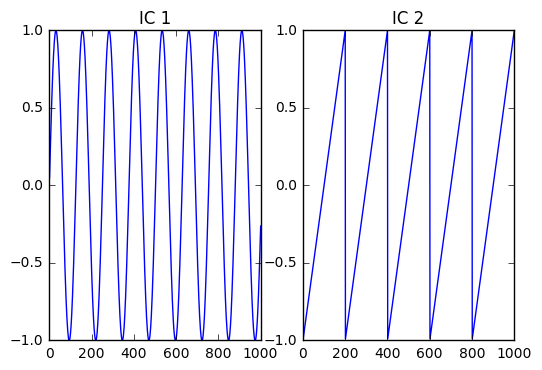

In [25]:
test(S_test)

#### 4.1.2 ICs by FastICA

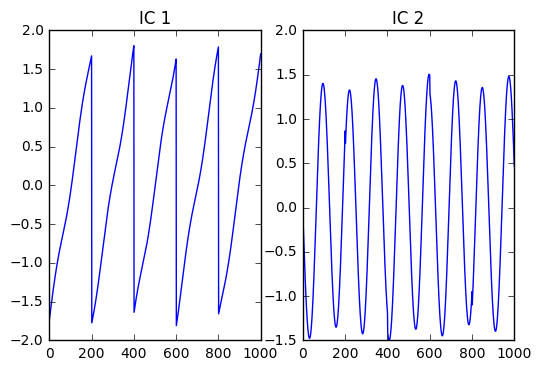

In [26]:
test(fastICA_ne(X_test,f = "logcosh",n_comp =2, alpha = 1,maxit = 200, tol = 0.0001)['S'])

### 4.2 Real World Data
 
#### 4.2.1 fMRI Data 
 
The real-world data set is a subsample of real fMRI data, which is from the 1000 Connectome Project. The data is a 30000 by 20 matrix, where 30000 is the number of voxels in brain. We applied our FastICA algorithm to the dataset, and separated the original mixed data to 20 independent components. From the plots, it seems that our algorithm successfully separated the mixed data. In the plot of the original data, we can see that all 20 features are very noised and have no apparent patterns. However, in the plot of the 20 independent components after using FastICA algorithm, it appears that the pattern of the signals become more apparent, even though there are still a lot of noise present. Considering the fact that this data set is real-world data with many noises, we would conclude that there is still more modifications and tests to be conducted to our algorithm in order to achieve more sensible results. With this potential for improvement in mind, we decided to proceed with caution and continue to improve our algorithm later.

In [27]:
fMRI.shape

(30000, 20)

Before applying the fastICA, a visualization of the original data

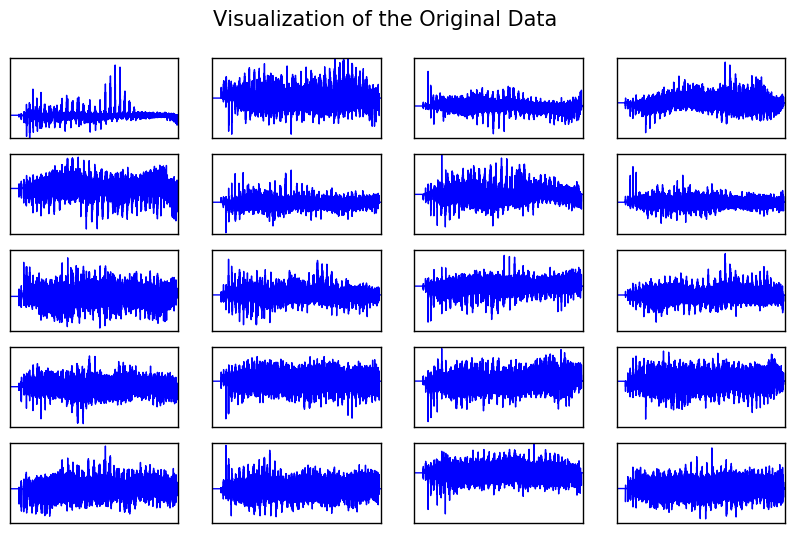

In [28]:
fig = plt.figure(figsize=(10,6)) 
for i in range(20):
    ax = plt.subplot(5,4,i+1)
    plt.plot(np.arange(30000)+1, fMRI[:,i])
    plt.xticks([])
    plt.yticks([])
fig.suptitle('Visualization of the Original Data', fontsize=15)
pass

After appplying FastICA algorithm, we visualize each independent component in the following plot

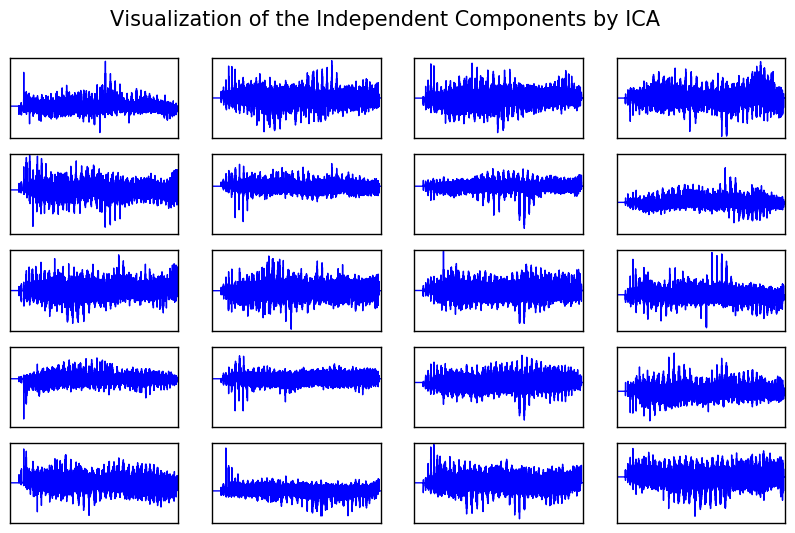

In [29]:
ica_fMRI = fastICA_ne(fMRI,f = "logcosh", alpha = 1,maxit = 200, tol = 0.0001)
S_fMRI = ica_fMRI['S']
fig = plt.figure(figsize=(10,6)) 
for i in range(20):
    ax = plt.subplot(5,4,i+1)
    plt.plot(np.arange(30000)+1, S_fMRI[:,i])
    plt.xticks([])
    plt.yticks([])
fig.suptitle('Visualization of the Independent Components by ICA', fontsize=15)
pass

#### 4.2.2 Finance Data

Our second real data application is in finance. Specifically, our application follows the thoughts of paper “A first application of independent component analysis to extracting structure from stock returns”[3].

We looked at the 2010-2017 stock prices of six top technology companies: Intel Corporation (INTC), Cisco Systems, Inc. (CSCO), QUALCOMM Incorporated (QCOM), eBay Inc. (EBAY), Apple Inc. (AAPL), Amazon.com, Inc. (AMZN) (data comes from Yahoo Finance). To make data more stationary, here we focused on the geometric growth of stock returns: $log⁡(p(t))-log⁡(p(t-1))$. Then we treated the stock returns of each company as a mixed signal, and used ICA to find potential driving factors. (Data manipulation details are in the Examples.ipynb) 

The stock return changes for the six technology companies from 2010-2017 is shows in the first plot below. Except two big jumps, their stock returns were relatively stable over time. The independent components obtained by our FastICA algorithm was show in the second plot below. Unlike the stock returns we observed, they were more fluctuant. Some of them offset the effect of others. Specifically, at the two stock return jump time points, there were two significant ICs jumps in different direction, suggesting interaction like income effect and substitution effect. Based on the ICs obtained through ICA, the reconstructed signals were shown in the third plot. It was almost the same as our observed stock returns, suggesting ICA did a good job.

Next, we took a close look at the most recent 100 trading days’ stock returns. The results were shown in the last eight small plots. Again, the ICA reconstructed signals almost resembled the patterns of the stock return data.

In [30]:
%run Test/finance.py
X_finance.shape

(1837, 6)

In [31]:
np.random.seed(663)
ica_finance = fastICA_ne(np.array(X_finance),f = "logcosh",n_comp=6, alpha = 1,maxit = 200, tol = 0.0001)

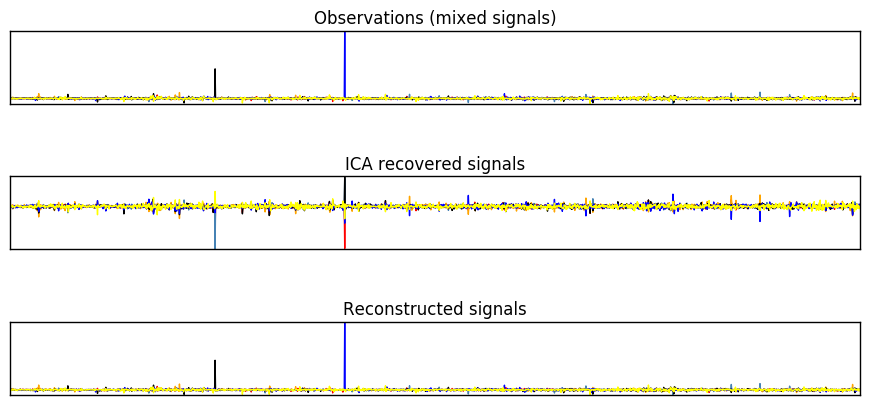

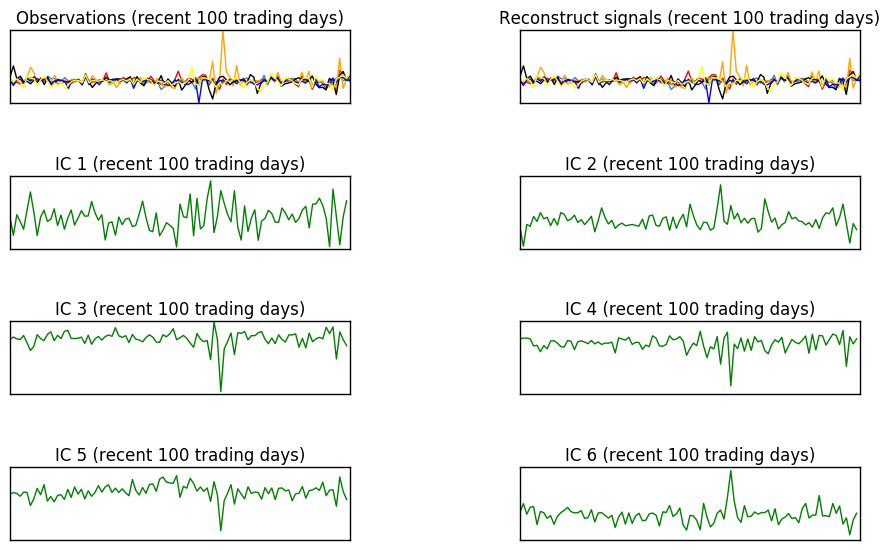

In [32]:
%run Test/plot_finance.py
plot_finance(X_finance,ica_finance)

## 5. Comparative Analysis with Competing Algorihtms
 
Our FastICA algorithm is compared with the PCA and factor analysis.They all solve a similar problem of finding linear representation of the multivariate data. Principal component analysis is a latent linear variable model which however assumes equal noise variance for each feature. This extra assumption makes probabilistic PCA faster as it can be computed in closed form.

Factor analysis is a simple linear generative model with Gaussian latent variables. The observations are assumed to be caused by a linear transformation of lower dimensional latent factors and added Gaussian noise.

In [33]:
%run Test/comparedata.py

In [34]:
S_ica = fastICA_ne(X_compare,f = "logcosh", alpha = 1,maxit = 200, tol = 0.0001)['S']

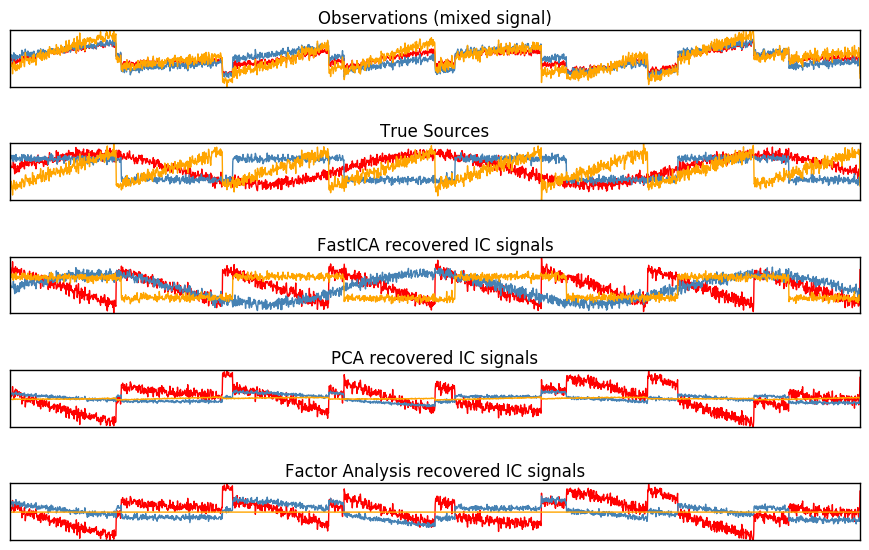

In [35]:
%run Test/plot_compare.py
plot_compare(X_compare,S_compare,S_ica)

## 6. Package

In [36]:
!pip install .

Processing /home/jovyan/work/fastica_lz


In [37]:
from fastica_lz import fastica_lz as lz

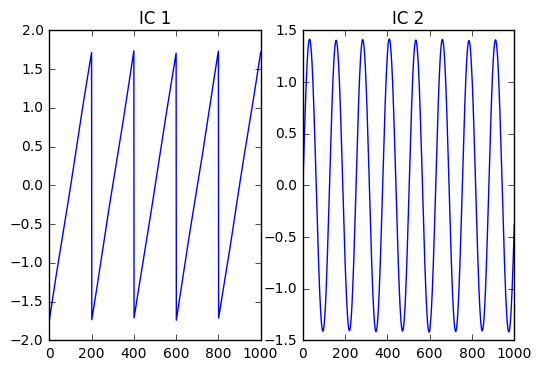

In [38]:
test(lz.fastica_s(X_test,f = "logcosh",n_comp =2, alpha = 1,maxit = 200, tol = 0.0001)['S'])

## 7. Discussion & Conclusion

   Independent Component Analysis(ICA) is originally developed for solving the cocktail party problem and the general blind source separation problem. When there are two people speaking simultaneously in the same room, and there are two microphones in the room recording their voices. Consequently, the two microphones give two signals, and each of the signal is the weighted sum of speech signals from two speakers. This is the cocktail-party problem. The ICA can help estimate the speech signals from two speakers from the mixed signals.
  
   Although ICA is designed to solve the cocktail party problem and signal separation problem, it can also be generalized to the fundamental problem of finding a linear representation of multivariate data. Each component of the representation is a linear combination of the original variable. Other similar algorithms that can solve the same linear transformation problems are principle component analysis, factor analysis and projection pursuit. Unlike these algorithms, independent component analysis should be used with assumption of non-gaussian data, and the components are as statistically independent as possible.
  
   There are two major limitations for the general ICA algorithm. First, the variance of the independent components cannot be determined. However, we can fix them either by setting the same scalar multiplier in both source matrix and mixing matrix. As a result, the magnitudes of the independent components can be fixed. In addition, the author also mentions another more natural way to fix is to assume each source matrix has unit variance. Second, we can’t determine the order of the independent components. As both the source matrix and mixing matrix are both unknown, we can freely change the order of the terms in the sum and even all any of the independent component the first. This is the inherent limitation of the ICA algorithm, therefore there is more exploration and research to do to solve this problem.[3]
 

# References

1. Hyvärinen, A. Independent Component Analysis: Algorithms and Applications. Neural Networks, 4-5(13), 411-430.

2. Hyvarinen, A. (2000, April 19). Ambiguities of ICA. Retrieved May 1, 2017, from http://cis.legacy.ics.tkk.fi/aapo/papers/IJCNN99_tutorialweb/node4.html

3. Back, A. D., & Weigend, A. S. (1997). A first application of independent component analysis to extracting structure from stock returns. International journal of neural systems, 8(04), 473-484.